In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

                


In [3]:
train = datasets.MNIST("./data", train =True, download =True, transform= train_transforms)
test = datasets.MNIST("./data", train =False , download =True, transform= test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
dropout_value = 0.1
from model import Model_3
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9            [-1, 6, 24, 24]              60
        MaxPool2d-10            [-1, 6, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             648
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [7]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    
    print('\nTrain set: Train loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
from torch.optim.lr_scheduler import StepLR
model = Model_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size =6, gamma =0.2)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.17084407806396484 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 63.26it/s]



Train set: Train loss: 222.3139, Train Accuracy: 52273/60000 (87.12%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


loss=0.02661733329296112 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.03it/s]



Train set: Train loss: 42.5962, Train Accuracy: 58488/60000 (97.48%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


loss=0.06273997575044632 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.27it/s]



Train set: Train loss: 32.3052, Train Accuracy: 58757/60000 (97.93%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


loss=0.06071806326508522 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.79it/s]



Train set: Train loss: 27.7839, Train Accuracy: 58951/60000 (98.25%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


loss=0.010917584411799908 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.10it/s]



Train set: Train loss: 25.0500, Train Accuracy: 59026/60000 (98.38%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


loss=0.016559936106204987 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.06it/s]



Train set: Train loss: 22.2925, Train Accuracy: 59136/60000 (98.56%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


loss=0.04645320773124695 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.52it/s]



Train set: Train loss: 19.1036, Train Accuracy: 59232/60000 (98.72%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9946/10000 (99.46%)

EPOCH: 7


loss=0.0531594343483448 batch_id=468: 100%|██████████████████████████████████████████| 469/469 [00:06<00:00, 67.22it/s]



Train set: Train loss: 18.3108, Train Accuracy: 59294/60000 (98.82%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


loss=0.005999105051159859 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.13it/s]



Train set: Train loss: 18.7081, Train Accuracy: 59280/60000 (98.80%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


loss=0.025018567219376564 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.93it/s]



Train set: Train loss: 18.2537, Train Accuracy: 59313/60000 (98.86%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


loss=0.016769595444202423 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.23it/s]



Train set: Train loss: 17.2190, Train Accuracy: 59299/60000 (98.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


loss=0.007224117871373892 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.33it/s]



Train set: Train loss: 16.6391, Train Accuracy: 59343/60000 (98.91%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


loss=0.08476585894823074 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 67.68it/s]



Train set: Train loss: 16.0025, Train Accuracy: 59370/60000 (98.95%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


loss=0.017997074872255325 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 70.12it/s]



Train set: Train loss: 16.9254, Train Accuracy: 59328/60000 (98.88%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


loss=0.020122181624174118 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.09it/s]



Train set: Train loss: 16.4232, Train Accuracy: 59360/60000 (98.93%)


Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)



In [10]:
#t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

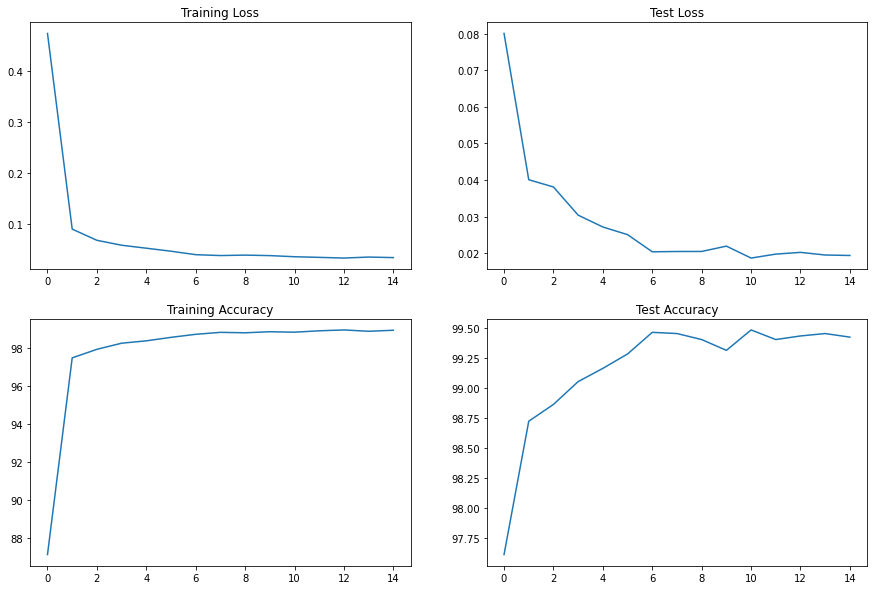

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


Text(0.5, 1.0, 'Loss per epoch')

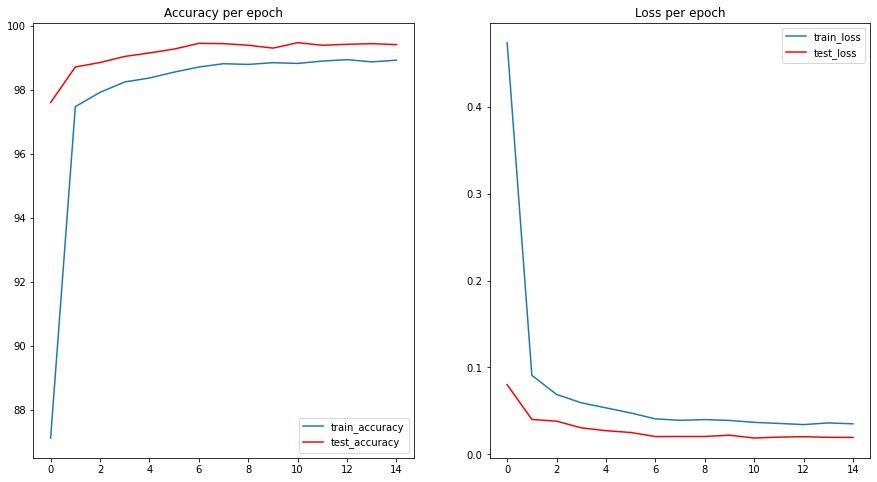

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_losses)
plt.plot(test_losses, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")
     

## Inference 

### Target 
1. Get set up
   Get transforms, Data Loader, Basic Working codd, training and test lopp 
   added the sheduler to change the learning rate ;  step_wise: 6; gamma: 0.2
2. Results 
   Parameters : 7.8 k Parameters  
   Epoch 15
   TRaining Acc: 98.87
   Test Acc: 99.42
   
3. Analysis 
   1. small  model 
   2. no overfit model 
   3. 7th epoch reached 99.43 
